In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False

## 1.加载数据

In [2]:
def loadDataSet(filename):
    X = []
    Y = []
    
    with open(filename, 'rb') as f:
        for idx, line in enumerate(f):
            line = line.decode('utf-8').strip()
            if not line:
                continue
            eles = line.split()
            eles = list(map(float, eles))
            
            if idx == 0:
                numFea = len(eles)
            X.append(eles[:-1])
            Y.append([eles[-1]])
    
    return np.array(X), np.array(Y)

## 2.定义sigmoid函数
$$ g(z) = \frac{1}{1+e^{(-z)}} $$

In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

## 3.定义代价函数
$$ J(\theta) = - \frac{1}{m} [ \sum_{i=1}^{m} (y^{(i)}\log(h_{\theta}(x^{(i)})) + (1-y^{(i)})\log{(1-h_{\theta}(x^{(i)}))})] + \lambda \frac{1}{2m} \sum_{j=1}^n \theta_j^2 $$ <br/>
其中，$ h_\theta(X) = g(\theta^T X) = sigmoid(\theta^T X)  $  <br/><br/>
$ \sum_{i=1}^{m} (y^{(i)}\log(h_{\theta}(x^{(i)})) + (1-y^{(i)})\log{(1-h_{\theta}(x^{(i)}))}) $ 为 $ \sum cost $ 表示拟合程度 <br/><br/>
$ \lambda \sum_{j=1}^n \theta_j^2 $ 表示 $ L_2 $ 正则化，用来表示模型复杂度（作用时不要过拟合）

In [8]:
def J(theta, X, Y, theLambda=0):
    m, n = X.shape
    h = sigmoid(np.dot(X, theta))
    J = (-1.0/m)*(np.dot(np.log(h).T,Y)+np.dot(np.log(1-h).T,1-Y)) + (theLambda/(2.0*m))*np.sum(np.square(theta[1:]))
    if np.isnan(J[0]):
        return np.inf
    # 其实J里面只有一个数值，需要取出该数值
    return J.flatten()[0]

## 4.定义梯度下降函数
$$ \theta_j := \theta_j - \alpha  \frac{1}{m}(h_\theta(x^{(i)})-y^{(i)})x_j^{(i)} - \alpha \frac{\lambda}{m}\theta_j $$

In [37]:
def gradient(X, Y, options):
    '''
    options.alpha 学习率
    options.theLambda 正则参数λ
    options.maxLoop 最大迭代轮次
    options.epsilon 判断收敛的阈值
    options.method
        - 'sgd' 随机梯度下降
        - 'bgd' 批量梯度下降
    '''
    
    m, n = X.shape
    
    # 初始化模型参数，n个特征对应n个参数
    theta = np.zeros((n,1))
    
    cost = J(theta, X, Y)  # 当前误差
    costs = [cost]
    thetas = [theta]
    
    # Python 字典dict.get(key, default=None)函数返回指定键的值，如果值不在字典中返回默认值
    alpha = options.get('alpha', 0.01)
    epsilon = options.get('epsilon', 0.00001)
    maxloop = options.get('maxloop', 1000)
    theLambda = float(options.get('theLambda', 0)) # 后面有 theLambda/m 的计算，如果这里不转成float，后面这个就全是0
    method = options.get('method', 'bgd')
    
    # 定义随机梯度下降
    def _sgd(theta):
        count = 0
        converged = False
        while count < maxloop:
            if converged :
                break
            # 随机梯度下降，每一个样本都更新
            for i in range(m):
                h =sigmoid(np.dot(X[i].reshape((1,n)), theta))
                
                theta = theta - alpha*((1.0/m)*X[i].reshape((n,1))*(h-Y[i]) + (theLambda/m)*np.r_[[[0]], theta[1:]])
                thetas.append(theta)
                cost = J(theta, X, Y, theLambda)
                costs.append(cost)
                if abs(costs[-1] - costs[-2]) < epsilon:
                    converged = True
                    break
            count += 1
        return thetas, costs, count
    
    # 定义批量梯度下降
    def _bgd(theta):
        count = 0
        converged = False
        while count < maxloop:
            if converged :
                break
            
            h = sigmoid(np.dot(X, theta))
            theta = theta - alpha*((1.0/m)*np.dot(X.T, (h-Y)) + (theLambda/m)*np.r_[[[0]],theta[1:]])
            
            thetas.append(theta)
            cost = J(theta, X, Y, theLambda)
            costs.append(cost)
            if abs(costs[-1] - costs[-2]) < epsilon:
                converged = True
                break
            count += 1
        return thetas, costs, count
    
    methods = {'sgd': _sgd, 'bgd': _bgd}
    return methods[method](theta)   

# 测试一下

### 1.加载数据

In [73]:
originX, Y = loadDataSet('./data/linear.txt')
m,n = originX.shape
X = np.concatenate((np.ones((m,1)), originX), axis=1)

**bgd**

In [78]:
# bgd
# 设置超参数
options = {
    'alpha':0.05,
    'epsilon':0.00000001,
    'maxloop':100000,
    'method':'bgd' # sgd
}
# 训练模型
import time
start = time.time()
thetas, costs, iterationCount = gradient(X, Y, options)
end = time.time()
btime = end - start
costs[-1], iterationCount, btime

(0.09333430872838289, 68010, 3.723447561264038)

Text(0,0.5,'$x_2$')

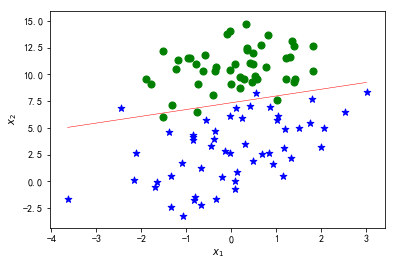

In [79]:
%matplotlib inline
# 绘制决策边界
for i in range(m):
    x = X[i]
    if Y[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

hSpots = np.linspace(X[:,1].min(), X[:,1].max(), 100)
theta0, theta1, theta2 = thetas[-1]

vSpots = -(theta0+theta1*hSpots)/theta2
plt.plot(hSpots, vSpots, color='red', linewidth=.5)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

Text(0,0.5,'代价J')

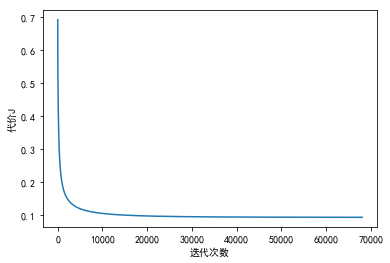

In [80]:
# 绘制误差曲线
plt.plot(range(len(costs)), costs)
plt.xlabel(u'迭代次数')
plt.ylabel(u'代价J')

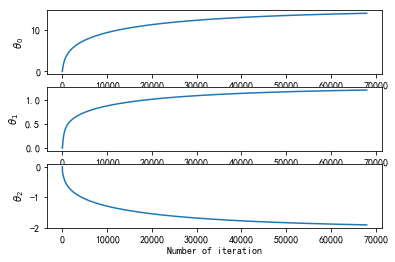

In [81]:
# 绘制参数theta变化
thetasFig, ax = plt.subplots(len(thetas[0]))
thetas = np.asarray(thetas)
for idx, sp in enumerate(ax):
    thetaList = thetas[:, idx]
    sp.plot(range(len(thetaList)), thetaList)
    sp.set_xlabel('Number of iteration')
    sp.set_ylabel(r'$\theta_%d$'%idx)

**sgd**

In [82]:
# sgd
options = {
    'alpha':0.5,
    'epsilon':0.00000001,
    'maxloop':100000,
    'method':'sgd' 
}
# 训练模型
import time
start = time.time()
S_thetas, S_costs, S_iterationCount = gradient(X, Y, options)
end = time.time()
btime = end - start
S_costs[-1], S_iterationCount, btime

(0.18906151167614432, 107, 0.5934193134307861)

Text(0,0.5,'$x_2$')

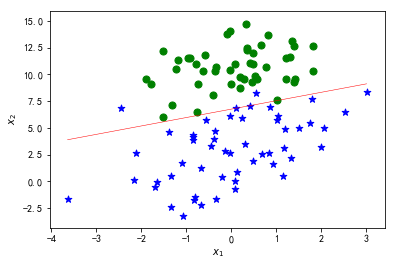

In [83]:
%matplotlib inline
# 绘制决策边界
for i in range(m):
    x = X[i]
    if Y[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

hSpots = np.linspace(X[:,1].min(), X[:,1].max(), 100)
theta0, theta1, theta2 = S_thetas[-1]

vSpots = -(theta0+theta1*hSpots)/theta2
plt.plot(hSpots, vSpots, color='red', linewidth=.5)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

Text(0,0.5,'代价J')

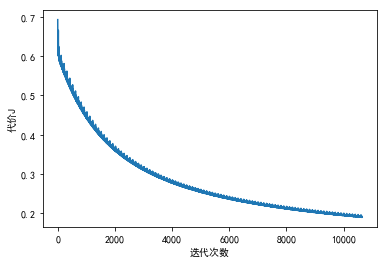

In [84]:
# 绘制误差曲线
plt.plot(range(len(S_costs)), S_costs)
plt.xlabel(u'迭代次数')
plt.ylabel(u'代价J')

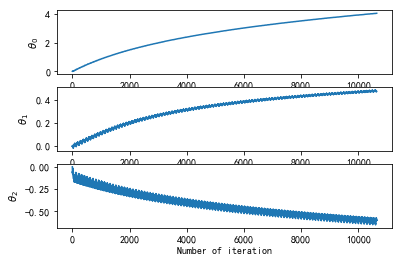

In [85]:
# 绘制参数theta变化
thetasFig, ax = plt.subplots(len(S_thetas[0]))
thetas = np.asarray(S_thetas)
for idx, sp in enumerate(ax):
    thetaList = thetas[:, idx]
    sp.plot(range(len(thetaList)), thetaList)
    sp.set_xlabel('Number of iteration')
    sp.set_ylabel(r'$\theta_%d$'%idx)

**绘制非线性决策边界**

In [87]:
from sklearn.preprocessing import PolynomialFeatures
# PolynomialFeatures专门生成多项式特征，并且多项式包含的是相互影响的特征集
# 比如：一个输入样本是２维的。形式如[a,b] ,则二阶多项式的特征集如下[1,a,b,a^2,ab,b^2]
# 非线性决策边界
ori_X, y = loadDataSet('./data/non_linear.txt')
m, n = ori_X.shape
X = np.concatenate((np.ones((m,1)), ori_X), axis=1)

# 生成阶数为6的多项式
poly = PolynomialFeatures(6)
XX = poly.fit_transform(X[:,1:3])
m, n = XX.shape
m, n

(118, 28)

In [103]:
# 训练数据
options = {
    'alpha': 1.0,
    'epsilon': 0.000001,
    'theLambda': 100, # 0
    'maxloop': 10000,
    'method': 'bgd'
}
thetas, errors, iterationCount = gradient(XX, y, options)

In [101]:
thetas[-1], costs[-1], iterationCount

(array([[ 0.01886043],
        [-0.01743511],
        [ 0.00586624],
        [-0.05490371],
        [-0.01317879],
        [-0.03829449],
        [-0.01840692],
        [-0.00770525],
        [-0.00890777],
        [-0.02268133],
        [-0.04331045],
        [-0.00236346],
        [-0.01410467],
        [-0.00350756],
        [-0.04127566],
        [-0.02095624],
        [-0.00470873],
        [-0.00358181],
        [-0.00630598],
        [-0.00501953],
        [-0.03187932],
        [-0.0340835 ],
        [-0.00107813],
        [-0.00700682],
        [-0.00038735],
        [-0.00796047],
        [-0.00155451],
        [-0.04097656]]), 0.09333430872838289, 9)

D:\Anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


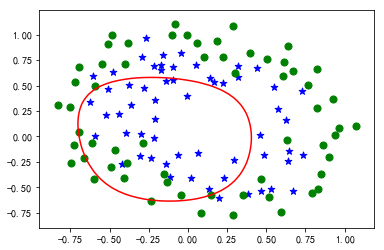

In [102]:
# theLambda = 100 时，欠拟合
for i in range(m):
    x = X[i]
    if y[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

# 绘制决策边界
x1Min,x1Max,x2Min,x2Max = X[:, 1].min(), X[:, 1].max(), X[:, 2].min(), X[:, 2].max()
xx1, xx2 = np.meshgrid(np.linspace(x1Min, x1Max), np.linspace(x2Min, x2Max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(thetas[-1]))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], colors='red', linewidth=.5)

D:\Anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


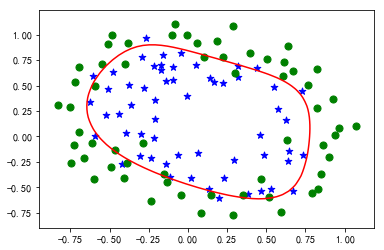

In [104]:
# theLambda = 0时拟合效果较好
for i in range(m):
    x = X[i]
    if y[i] == 1:
        plt.scatter(x[1], x[2], marker='*', color='blue', s=50)
    else:
        plt.scatter(x[1], x[2], marker='o', color='green', s=50)

# 绘制决策边界
x1Min,x1Max,x2Min,x2Max = X[:, 1].min(), X[:, 1].max(), X[:, 2].min(), X[:, 2].max()
xx1, xx2 = np.meshgrid(np.linspace(x1Min, x1Max), np.linspace(x2Min, x2Max))
h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(thetas[-1]))
h = h.reshape(xx1.shape)
plt.contour(xx1, xx2, h, [0.5], colors='red', linewidth=.5)